<a href="https://colab.research.google.com/github/thierrysayah/database-project/blob/master/1D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot
from numpy import zeros
from numpy import ones
from numpy.random import randn


In [ ]:
def calculate(x):
 return x*x

In [ ]:
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

outputs = [calculate(x) for x in inputs]

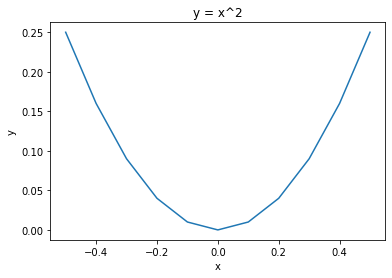

In [ ]:
pyplot.title("y = x^2")
pyplot.xlabel("x")
pyplot.ylabel("y")
pyplot.plot(inputs, outputs)
pyplot.show()


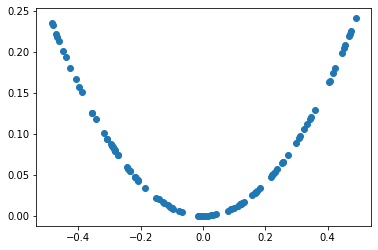

In [ ]:
from numpy.random import rand
from numpy import hstack

def generate_samples(n= 100):
  x1 = rand(n) - 0.5
  x2 = x1 * x1

  x1 = x1.reshape(n,1)
  x2 = x2.reshape(n,1)

  return hstack((x1,x2))

data = generate_samples()

pyplot.scatter(data[:,0], data[:,1])
pyplot.show()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 25)                75        
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


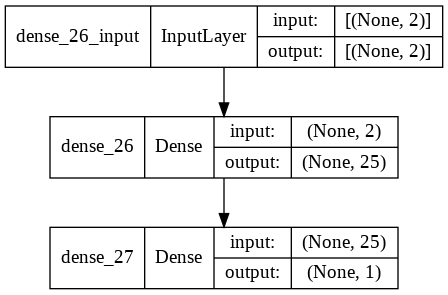

In [ ]:
#define discriminator

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

def  define_discriminator(n_inputs = 2):
  model = Sequential()
  model.add(Dense(25,activation = 'relu', kernel_initializer = 'he_uniform',
                  input_dim = n_inputs))
  model.add(Dense(1,activation = 'sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = define_discriminator()

model.summary()

plot_model(model, to_file = 'discriminator_plot.png', show_shapes=True, show_layer_names = True)

In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [-0.5, 0.5]
  X1 = rand(n) - 0.5
  # generate outputs X^2
  X2 = X1 * X1
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

In [ ]:
# generate n fake samples with class labels
def generate_fake_sample(n):
  # generate inputs in [-1, 1]
  X1 = -1 + rand(n) * 2
  # generate outputs in [-1, 1]
  X2 = -1 + rand(n) * 2
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = zeros((n, 1))
  return X, y


In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n, 1))
  return X, y

In [ ]:
def train_discriminator(model, n_epochs =1000, n_batch =128):
  half_batch = int(n_batch/2)
# run epochs manually
  for i in range(n_epochs):
    #generate real examples
    X_real, y_real = generate_real_samples(half_batch)
    # update model
    model.train_on_batch(X_real, y_real)
    #generate fake examples
    X_fake , y_fake = generate_fake_samples(half_batch)
    #update model
    model.train_on_batch(X_fake,  y_fake)
    #evaluate model
    _, acc_real = model.evaluate(X_real,y_real, verbose=0)
    _, acc_fake = model.evaluate(X_fake, y_fake, verbose =0)
    print(i, acc_real, acc_fake)

#define the descriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 15)                90        
                                                                 
 dense_31 (Dense)            (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


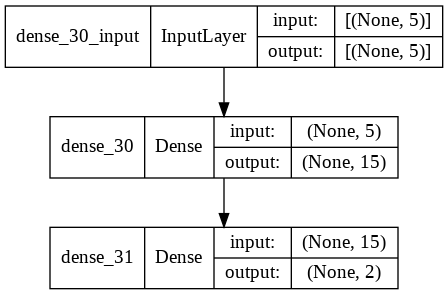

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform',
  input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))

  return model
# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

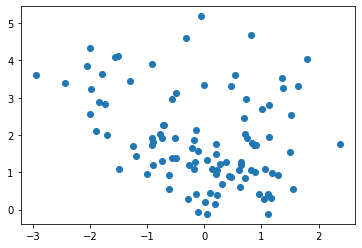

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)

  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # plot the results
  pyplot.scatter(X[:, 0], X[:, 1])
  pyplot.show()
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 2)                 122       
                                                                 
 sequential_19 (Sequential)  (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


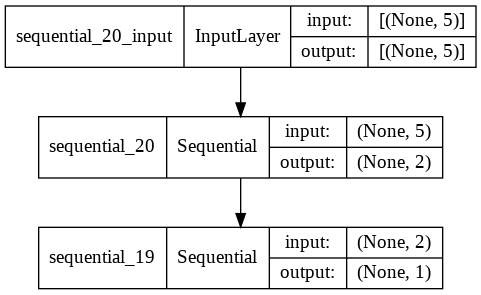

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator
  model.add(discriminator)
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128,n_eval=2000):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator✬s error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)

1999 0.6200000047683716 0.41999998688697815


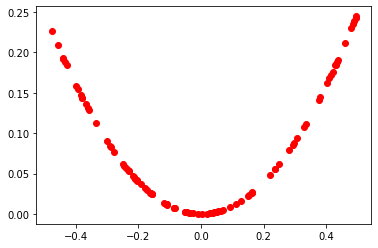

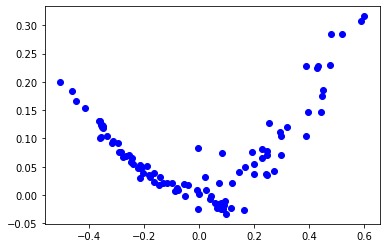

3999 0.6600000262260437 0.47999998927116394


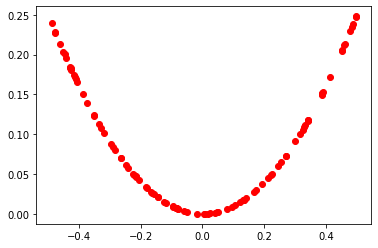

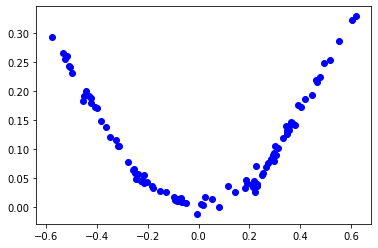

5999 0.6399999856948853 0.5199999809265137


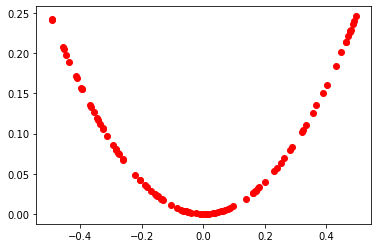

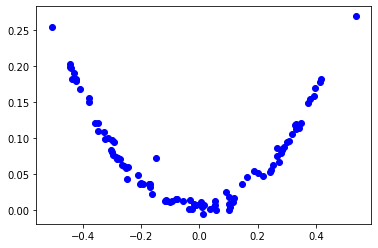

7999 0.3100000023841858 0.6600000262260437


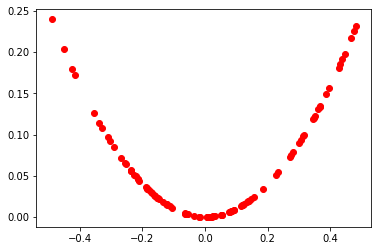

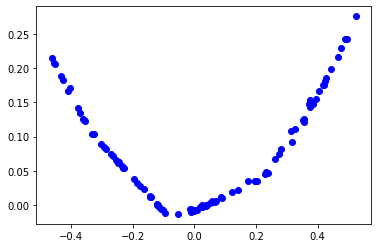

9999 0.7599999904632568 0.3799999952316284


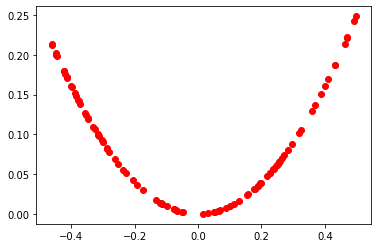

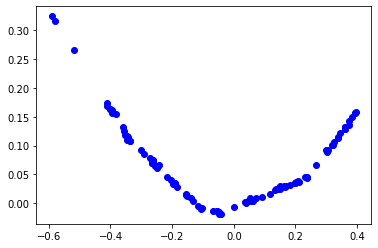

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
  pyplot.show()
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  pyplot.show()
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)